In [21]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Lipinski
from rdkit.Geometry import Point3D

import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import HTML

import numpy as np
import scipy.stats as stats
import mordred
from mordred import Calculator, descriptors


import xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel



In [2]:
#pd.set_option('display.max_rows', 500)

In [3]:
# Read Data:
file = '../data/qspr-dataset-02.sdf'

frame = PandasTools.LoadSDF(file,
                            smilesName='SMILES',
                            molColName='Molecule',
                            includeFingerprints=True) \
                            .reset_index() \
                            .set_index("ID") \
                            .drop(columns=["index"])
print('The provided dataset contains {} molecules.'.format(frame.shape[0]))
# change pLC50 type to float
frame = frame.astype({"pLC50": float})

RDKit WARNING: [12:13:53] Warning: molecule is tagged as 3D, but all Z coords are zero


The provided dataset contains 352 molecules.


## Investigate Data

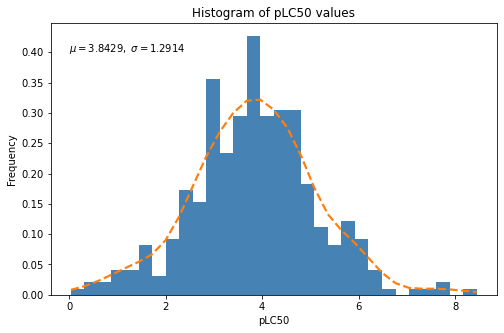

In [51]:
# Check distribution of pLC50 property 
plt.figure(figsize=(8,5))
n,x,_ = plt.hist(frame["pLC50"].to_list(), bins = 30, density=True,facecolor='steelblue')
plt.ylabel('Frequency',rotation=90)
density = stats.gaussian_kde(frame["pLC50"].to_list())
plt.xlabel('pLC50')
plt.text(0, 0.4, r'$\mu={},\ \sigma={}$'.format(round(frame["pLC50"].mean(),4),
                                                round(frame["pLC50"].std(),4)))
plt.title('Histogram of pLC50 values')
plt.plot(x, density(x),linestyle='dashed',lw=2.2)

In [5]:
frame.describe()

,pLC50
count,352.000000
mean,3.842466
std,1.289585
min,0.037000
25%,3.020750
50%,3.832500
75%,4.657750
max,8.447000


## Preprocessing
Initial preprocessing based on the smiles and RDKIT molecule.

In [6]:
### Functions for Preprocessing:

def add_Hydrogens(x):
    """
    Add Hydrogens to all molecules
    """
    x = Chem.AddHs(x)
    AllChem.EmbedMolecule(x, randomSeed=0xf00d)
    return x



def is_organic(smile):
    """
    Function that tests if a smile is organic or not
    """
    # list containing organic atomic numbers
    organic = set([5, 6, 7, 8, 9, 15, 16, 17, 35, 53])
    
    try:
        mol = Chem.MolFromSmiles(smile)
        atom_num_list = set([atom.GetAtomicNum() for atom in mol.GetAtoms()])

        organic_mol = (atom_num_list <= organic)
    
        if organic_mol:
            return True
        else:
            return False
    except:
        return False

In [7]:
# Filter out inorganic molecules
organic = frame['SMILES'].apply(is_organic)
frame = frame.drop(frame[-organic].index)
print('Number of inorganic molecules found: {}'.format(np.size(organic)-np.count_nonzero(organic)))

# Add Hydrogens to all molecules
frame["Molecule_processed"] = frame["Molecule"].apply(lambda x: add_Hydrogens(x))


Number of inorganic molecules found: 1


,pLC50,SMILES,Molecule,Molecule_processed
ID,,,,
Row0,2.504,c1cc[nH]c1,,
Row1,4.818,CCCCCCCCCCO,,
Row2,0.842,CC(C)O,,
Row3,4.228,O=[N+]([O-])c1ccc(O)c([N+](=O)[O-])c1,,
Row5,3.423,CCC1(CCC(C)C)C(=O)NC(=O)NC1=O,,

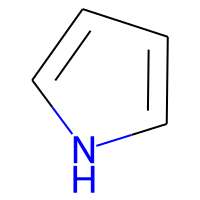
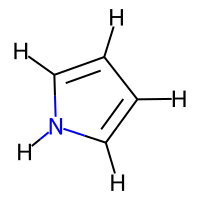
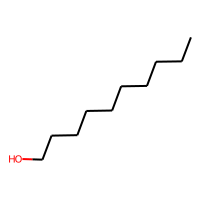
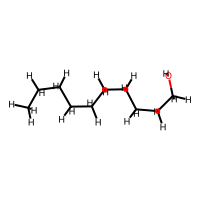
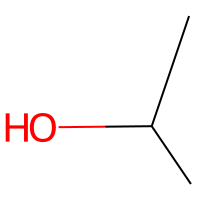
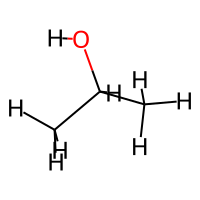
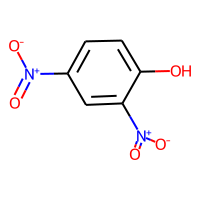
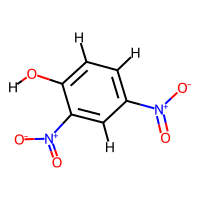
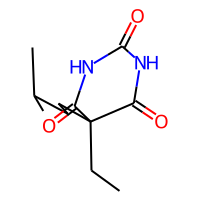
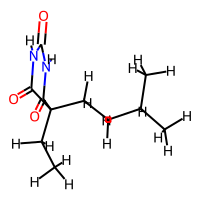

In [8]:
HTML(frame.head().to_html())

In [9]:
# Save preprocessed data
rdkit.Chem.PandasTools.WriteSDF(frame, out="preprocessed_data.sdf", molColName="Molecule_processed")

## Add more Descriptors
Until now: only SMILES and processed molecules. Add descriptors that could influence toxicity. 

,pLC50,SMILES,Molecule,Molecule_processed
ID,,,,
Row0,2.504,c1cc[nH]c1,,
Row1,4.818,CCCCCCCCCCO,,

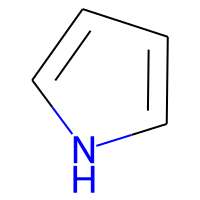
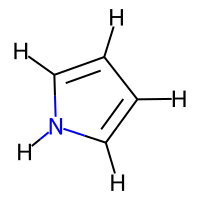
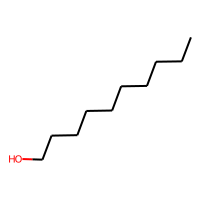
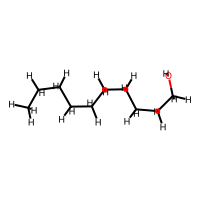

In [10]:
HTML(frame.head(2).to_html())

In [11]:
# what could influence toxicity?

# structural descriptors:
frame["heavy_atom_count"] = frame["Molecule"].apply(lambda x: Lipinski.HeavyAtomCount(x))
frame["h_acceptors"] = frame["Molecule"].apply(lambda x: Lipinski.NumHAcceptors(x))
frame["h_donors"] = frame["Molecule"].apply(lambda x: Lipinski.NumHDonors(x))
frame["rotatable_bond_count"] = frame["Molecule"].apply(lambda x: Lipinski.NumRotatableBonds(x))
frame["aromatic_ring_count"] = frame["Molecule"].apply(lambda x: Lipinski.NumAromaticRings(x))

# Calculate additional descriptors using modred:
calc_2D = Calculator(descriptors, ignore_3D=True)
#calc_3D = Calculator(descriptors, ignore_3D=False)
mordred_desc_frame = calc_2D.pandas(frame["Molecule"])
# change type from object to float
mordred_desc_frame = mordred_desc_frame.astype('float64')


"""calc = mordred.Calculator()
calc.register(mordred.AtomCount.AtomCount("HeavyAtom"))
calc.register(mordred.Aromatic.AromaticAtomsCount)
calc.register(mordred.RotatableBond.RotatableBondsCount)
calc.register(mordred.BondCount.BondCount("any", False))
calc.register(mordred.Aromatic.AromaticBondsCount)
calc.register(mordred.Polarizability.APol)
calc.register(mordred.Polarizability.BPol)
calc.register(mordred.SLogP)
calc.register(mordred.WienerIndex.WienerIndex(True))


descriptors=[]
for desc in calc.descriptors:
    descriptors.append(str(desc))
    
print(descriptors)

frame["mordred"] = frame["Molecule"].apply(lambda x: calc(x))
frame[descriptors] = pd.DataFrame(frame.mordred.tolist(), index= frame.index)
frame.drop(columns = ["mordred"], inplace = True)
print(frame)"""

  3%|▎         | 11/351 [00:01<00:45,  7.48it/s]

/home/caro/anaconda3/envs/qspr_comp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 351/351 [00:28<00:00, 12.14it/s]


'calc = mordred.Calculator()\ncalc.register(mordred.AtomCount.AtomCount("HeavyAtom"))\ncalc.register(mordred.Aromatic.AromaticAtomsCount)\ncalc.register(mordred.RotatableBond.RotatableBondsCount)\ncalc.register(mordred.BondCount.BondCount("any", False))\ncalc.register(mordred.Aromatic.AromaticBondsCount)\ncalc.register(mordred.Polarizability.APol)\ncalc.register(mordred.Polarizability.BPol)\ncalc.register(mordred.SLogP)\ncalc.register(mordred.WienerIndex.WienerIndex(True))\n\n\ndescriptors=[]\nfor desc in calc.descriptors:\n    descriptors.append(str(desc))\n    \nprint(descriptors)\n\nframe["mordred"] = frame["Molecule"].apply(lambda x: calc(x))\nframe[descriptors] = pd.DataFrame(frame.mordred.tolist(), index= frame.index)\nframe.drop(columns = ["mordred"], inplace = True)\nprint(frame)'

In [12]:
mordred_desc_frame

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
ID,,,,,,,,,,,,,,,,,,,,,
Row0,3.535534,3.535534,0.0,0.0,6.472136,2.000000,3.618034,6.472136,1.294427,2.525424,...,7.147559,41.004802,67.042199,6.704220,15.0,0.0,20.0,20.0,1.250000,1.250000
Row1,7.071068,6.765664,0.0,0.0,13.191508,1.931852,3.863703,13.191508,1.199228,3.202455,...,7.601402,37.236738,158.167065,4.792941,220.0,8.0,38.0,36.0,4.250000,3.000000
Row2,2.449490,2.449490,0.0,0.0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,6.188264,24.179697,60.057515,5.004793,9.0,0.0,12.0,9.0,3.111111,1.000000
Row3,9.618017,9.150803,0.0,0.0,15.158804,2.337747,4.675495,15.158804,1.166062,3.457918,...,9.300821,43.952649,184.012021,10.824237,240.0,18.0,62.0,70.0,6.305556,2.916667
Row5,11.737438,11.245612,0.0,0.0,18.468321,2.459010,4.918020,18.468321,1.154270,3.665326,...,9.778094,48.534478,226.131742,6.650934,418.0,26.0,78.0,91.0,7.756944,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Row347,6.651690,6.355891,0.0,0.0,10.792280,2.245827,4.491654,10.792280,1.199142,3.099448,...,8.806724,37.839725,124.074896,7.298523,84.0,10.0,42.0,46.0,4.083333,2.027778
Row348,5.944584,6.068455,0.0,0.0,9.191688,2.278414,4.278414,9.191688,1.148961,2.995422,...,8.593599,50.007331,111.068414,6.533436,59.0,7.0,38.0,42.0,3.833333,1.777778
Row349,7.358797,6.989468,0.0,0.0,11.908678,2.242838,4.485676,11.908678,1.190868,3.197246,...,8.830689,39.160939,198.963276,12.435205,117.0,11.0,46.0,50.0,4.333333,2.277778


In [13]:
# Too many descriptors
print('Nr of molecules:   {}'.format(mordred_desc_frame.shape[0]))
print('Nr of descriptors: {}'.format(mordred_desc_frame.shape[1]))
t = len(np.nonzero(np.sum(mordred_desc_frame.isna()).values)[0])
print('Nr of descriptors containing NaN values: {}'.format(t))

Nr of molecules:   351
Nr of descriptors: 1613
Nr of descriptors containing NaN values: 701


In [14]:
# drop columns which contain missing values
mordred_desc_frame = mordred_desc_frame.dropna(axis=1)
print('Nr of descriptors after dropping nan: {}'.format(mordred_desc_frame.shape[1]))

Nr of descriptors after dropping nan: 912


# Split Train / Test / Validation (CV)

In [58]:
# divide features and response
y = frame[["pLC50"]].values
X = mordred_desc_frame #frame.drop(columns = ["pLC50", "SMILES", "Molecule", "Molecule_processed"])

# split both into test and training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#scaler
stds = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y)
X_raw_train = X_train

(245, 912)
(106, 912)
(245, 1)
(106, 1)


## Feature selection using Lasso

In [16]:
# For hyperparameter tuning of Lasso regression:

# select features
features = X.columns.values

# generate pipeline that will scale the data and then apply the model
pipeline = Pipeline([('scaler',StandardScaler()),('model',linear_model.Lasso())])

# optimize alpha -> test values between 0.1 and 5 
# calculate mean of 5 fold cross validation 
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,5,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",
                      verbose=3)
# fit grid 
search.fit(X_train,y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-0.423, total=   0.1s
[CV] model__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................... model__alpha=0.1, score=-0.419, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ....... model__alpha=0.1, score=-6101148556991.180, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-0.477, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ................... model__alpha=0.1, score=-0.558, total=   0.1s
[CV] model__alpha=0.2 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ................... model__alpha=0.2, score=-0.505, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-0.482, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ....... model__alpha=0.2, score=-4437479034442.489, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-0.587, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ................... model__alpha=0.2, score=-0.637, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................
[CV] ... model__alpha=0.30000000000000004, score=-0.573, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................
[CV] ... model__alpha=0.30000000000000004, score=-0.513, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................
[CV]  

[CV] .... model__alpha=1.3000000000000003, score=-1.768, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV] .... model__alpha=1.4000000000000001, score=-1.399, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV] .... model__alpha=1.4000000000000001, score=-1.548, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV] .... model__alpha=1.4000000000000001, score=-1.973, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV] .... model__alpha=1.4000000000000001, score=-1.909, total=   0.1s
[CV] model__alpha=1.4000000000000001 .................................
[CV] .... model__alpha=1.4000000000000001, score=-1.768, total=   0.1s
[CV] model__alpha=1.5000000000000002 .................................
[CV] .... model__alpha=1.5000000000000002, score=-1.399, total=   0.1s
[CV] model__alpha=1.5000000000000002 .................................
[CV] .

[CV] .... model__alpha=2.5000000000000004, score=-1.768, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] ................... model__alpha=2.6, score=-1.399, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] ................... model__alpha=2.6, score=-1.548, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] ................... model__alpha=2.6, score=-1.973, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] ................... model__alpha=2.6, score=-1.909, total=   0.1s
[CV] model__alpha=2.6 ................................................
[CV] ................... model__alpha=2.6, score=-1.768, total=   0.1s
[CV] model__alpha=2.7 ................................................
[CV] ................... model__alpha=2.7, score=-1.399, total=   0.1s
[CV] model__alpha=2.7 ................................................
[CV] .

[CV] .... model__alpha=3.8000000000000003, score=-1.399, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................
[CV] .... model__alpha=3.8000000000000003, score=-1.548, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................
[CV] .... model__alpha=3.8000000000000003, score=-1.973, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................
[CV] .... model__alpha=3.8000000000000003, score=-1.909, total=   0.1s
[CV] model__alpha=3.8000000000000003 .................................
[CV] .... model__alpha=3.8000000000000003, score=-1.768, total=   0.1s
[CV] model__alpha=3.9000000000000004 .................................
[CV] .... model__alpha=3.9000000000000004, score=-1.399, total=   0.1s
[CV] model__alpha=3.9000000000000004 .................................
[CV] .... model__alpha=3.9000000000000004, score=-1.548, total=   0.1s
[CV] model__alpha=3.9000000000000004 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:   20.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [17]:
# get best parameter
print('Best alpha parameter for Lasso: {}'.format(search.best_params_['model__alpha']))

Best alpha parameter for Lasso: 0.5


In [18]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

In [19]:
print('Nr of features selected: {}'.format(sum(importance > 0)))
important_features = np.array(features)[importance > 0]
print(important_features)

Nr of features selected: 3
['ZMIC0' 'FilterItLogS' 'SLogP']


In [59]:
#scale data
X_train_scaled = stds.transform(X_train)
Y_train_scaled = scaler_y.transform(y_train)
lasso = Lasso(alpha=0.05,max_iter=10000,random_state=1).fit(X_train_scaled, Y_train_scaled)
coefficients = lasso.coef_
importance = np.abs(coefficients)
print('Nr of features selected: {}'.format(sum(importance > 0)))
important_features = np.array(features)[importance > 0]
print(important_features)

Nr of features selected: 37
['ATSC4c' 'ATSC3dv' 'ATSC5se' 'ATSC4i' 'ATSC6i' 'AATSC2Z' 'MATS1s'
 'GATS1p' 'GATS1i' 'RNCG' 'NdCH2' 'NdsCH' 'NsssN' 'SdssC' 'SdssS' 'IC5'
 'SIC5' 'MIC1' 'ZMIC0' 'FilterItLogS' 'PEOE_VSA6' 'PEOE_VSA9' 'PEOE_VSA10'
 'PEOE_VSA12' 'SMR_VSA4' 'SMR_VSA9' 'SlogP_VSA4' 'EState_VSA2'
 'EState_VSA5' 'VSA_EState9' 'n6HRing' 'n9FRing' 'n9FHRing' 'n9FARing'
 'n9FAHRing' 'SLogP' 'JGI1']


# Model training

### 1. Before Feature Selection:

In [38]:
def get_errors(y_true,y_pred,model_name="Model"):
    """
    This function computes three different measurements
    for model validation: Mean absulute error (MAE), 
    Root mean squared error (rmse) and R².
    """
    err_mae=mae(y_true,y_pred).round(4)
    err_rmse=np.sqrt(mse(y_true,y_pred)).round(4)
    err_r2=r2(y_true,y_pred).round(4)
 
    print(model_name+" MAE:"+str(err_mae)+" RMSE:"+str(err_rmse)+" R2:"+str(err_r2))
    
    return err_mae,err_rmse,err_r2

In [ ]:
#XGBoost
xgboost_model = xgboost.XGBRegressor(n_estimators=100)
xgboost_model.fit(X_raw_train, y_train)

#Random Forest
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_raw_train, y_train.ravel())

#SVM oder so kp bin kein Experte (Caro :) )
svm_model = SVR()
svm_model.fit(stds.transform(X_raw_train), y_train.ravel())

#KNN
knn_model = KNeighborsRegressor()
knn_model.fit(stds.transform(X_raw_train), y_train)

#ANN
ann_model = MLPRegressor(activation='tanh', hidden_layer_sizes=(200), max_iter=500, random_state=0, solver='adam')
ann_model.fit(X_raw_train, y_train.ravel())



In [ ]:
# Predict using test and training
pred_xgb_test = xgboost_model.predict(X_test)
pred_xgb_train = xgboost_model.predict(X_raw_train)

pred_rf_test = rf_model.predict(X_test)
pred_rf_train = rf_model.predict(X_raw_train)

pred_svm_test = svm_model.predict(stds.transform(X_test))
pred_svm_train = svm_model.predict(stds.transform(X_raw_train))

pred_knn_test = knn_model.predict(stds.transform(X_test))
pred_knn_train = knn_model.predict(stds.transform(X_raw_train))

pred_ann_test = ann_model.predict(X_test)
pred_ann_train = ann_model.predict(X_raw_train)


In [ ]:
print("\nPerformance on Training set:")
get_errors(y_train, pred_rf_train, "->Random Forest ")
get_errors(y_train, pred_xgb_train, "-> XGBoost      ")
get_errors(y_train, pred_svm_train, "-> SVM          ")
get_errors(y_train, pred_knn_train, "-> KNN          ")
get_errors(y_train, pred_ann_train, "-> ANN          ")

print("\nPerformance on Testing set:")
get_errors(y_test, pred_rf_test,  "->Random Forest ")
get_errors(y_test, pred_xgb_test, "-> XGBoost      ")
get_errors(y_test, pred_svm_test, "-> SVM          ")
get_errors(y_test, pred_knn_test, "-> KNN          ")
get_errors(y_test, pred_ann_test, "-> ANN          ")




### 2. After Feature Selection:

In [60]:
X_test = X_test[important_features]
X_train = X_train[important_features]
#X_test

In [61]:
### Train models: 
stds = StandardScaler().fit(X_train)

#XGBoost
xgboost_model = xgboost.XGBRegressor(n_estimators=100)
xgboost_model.fit(X_train, y_train)

#Random Forest
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train.ravel())

#SVM oder so kp bin kein Experte (Caro :) )
svm_model = SVR()
svm_model.fit(stds.transform(X_train), y_train.ravel())

#KNN
knn_model = KNeighborsRegressor()
knn_model.fit(stds.transform(X_train), y_train)

#ANN
ann_model = MLPRegressor(activation='tanh', hidden_layer_sizes=(200), max_iter=500, random_state=0, solver='adam')
ann_model.fit(X_train, y_train.ravel())

#### Predict test and training data

# For XGBoost:
pred_xgb_test = xgboost_model.predict(X_test)
pred_xgb_train = xgboost_model.predict(X_train)

# For Random Forest:
pred_rf_test = rf_model.predict(X_test)
pred_rf_train = rf_model.predict(X_train)

# For SVM Regression:
pred_svm_test = svm_model.predict(stds.transform(X_test))
pred_svm_train = svm_model.predict(stds.transform(X_train))

# For KNN:
pred_knn_test = knn_model.predict(stds.transform(X_test))
pred_knn_train = knn_model.predict(stds.transform(X_train))

# For ANN:
pred_ann_test = ann_model.predict(X_test)
pred_ann_train = ann_model.predict(X_train)


### Compute performance measurements:
print("\nPerformance on Training set:")
get_errors(y_train, pred_rf_train, "->Random Forest ")
get_errors(y_train, pred_xgb_train, "-> XGBoost      ")
get_errors(y_train, pred_svm_train, "-> SVM          ")
get_errors(y_train, pred_knn_train, "-> KNN          ")
get_errors(y_train, pred_ann_train, "-> ANN          ")

print("\nPerformance on Testing set:")
get_errors(y_test, pred_rf_test,  "->Random Forest ")
get_errors(y_test, pred_xgb_test, "-> XGBoost      ")
get_errors(y_test, pred_svm_test, "-> SVM          ")
get_errors(y_test, pred_knn_test, "-> KNN          ")
get_errors(y_test, pred_ann_test, "-> ANN          ")


Performance on Training set:
->Random Forest  MAE:0.1751 RMSE:0.2333 R2:0.9681
-> XGBoost       MAE:0.0006 RMSE:0.0008 R2:1.0
-> SVM           MAE:0.2688 RMSE:0.4195 R2:0.8969
-> KNN           MAE:0.4469 RMSE:0.5715 R2:0.8087
-> ANN           MAE:0.0727 RMSE:0.1078 R2:0.9932

Performance on Testing set:
->Random Forest  MAE:0.4616 RMSE:0.6329 R2:0.7409
-> XGBoost       MAE:0.4533 RMSE:0.6452 R2:0.7307
-> SVM           MAE:0.5569 RMSE:0.8214 R2:0.5636
-> KNN           MAE:0.5238 RMSE:0.6871 R2:0.6947
-> ANN           MAE:0.6485 RMSE:0.8783 R2:0.501


(0.6485, 0.8783, 0.501)